   ProductionVolume  ProductionCost  SupplierQuality  DeliveryDelay  \
0               202    13175.403783        86.648534              1   
1               535    19770.046093        86.310664              4   
2               960    19060.820997        82.132472              0   
3               370     5647.606037        87.335966              5   
4               206     7472.222236        81.989893              3   

   DefectRate  QualityScore  MaintenanceHours  DowntimePercentage  \
0    3.121492     63.463494                 9            0.052343   
1    0.819531     83.697818                20            4.908328   
2    4.514504     90.350550                 1            2.464923   
3    0.638524     67.628690                 8            4.692476   
4    3.867784     82.728334                 9            2.746726   

   InventoryTurnover  StockoutRate  WorkerProductivity  SafetyIncidents  \
0           8.630515      0.081322           85.042379                0   
1       

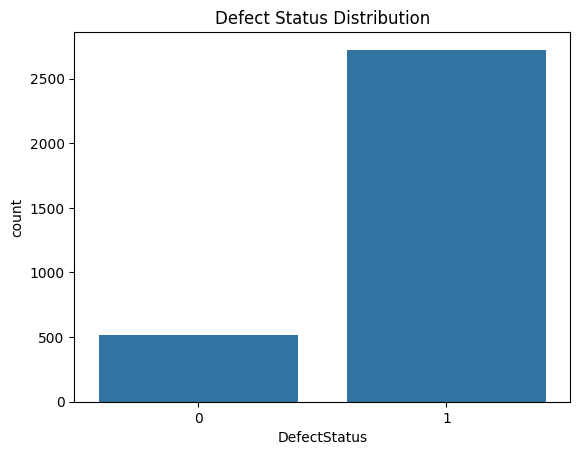

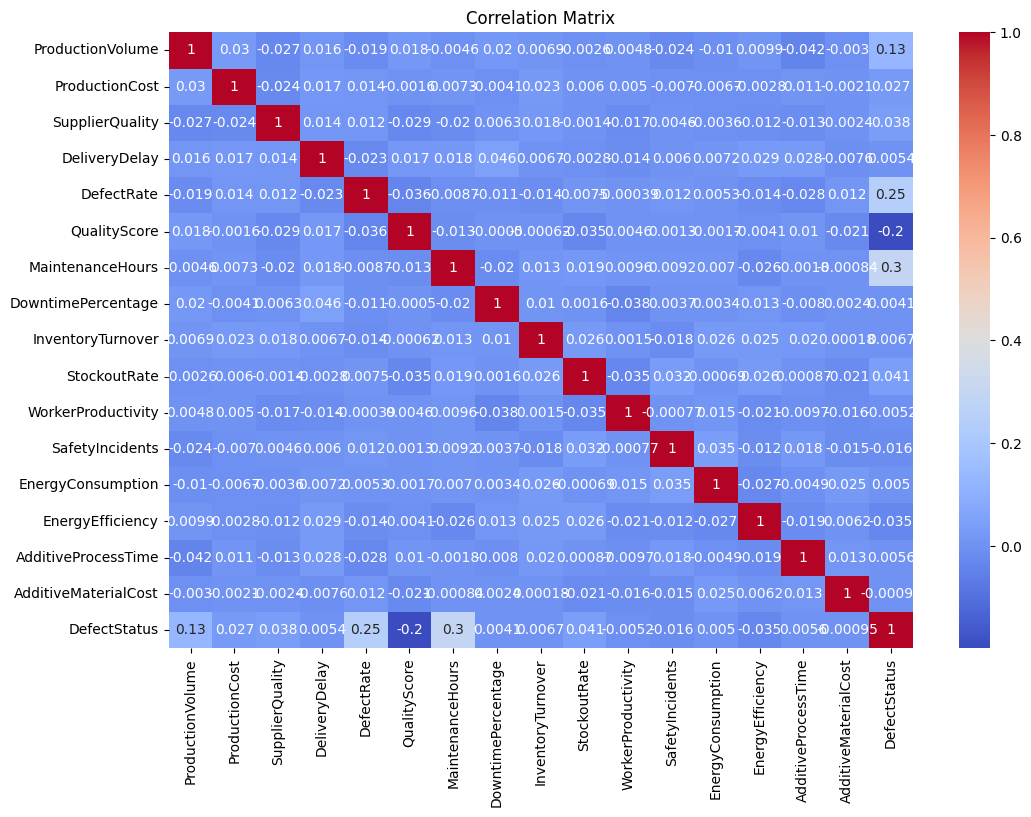

랜덤 포레스트 모델 학습을 시작합니다...
랜덤 포레스트 모델 학습이 완료되었습니다.


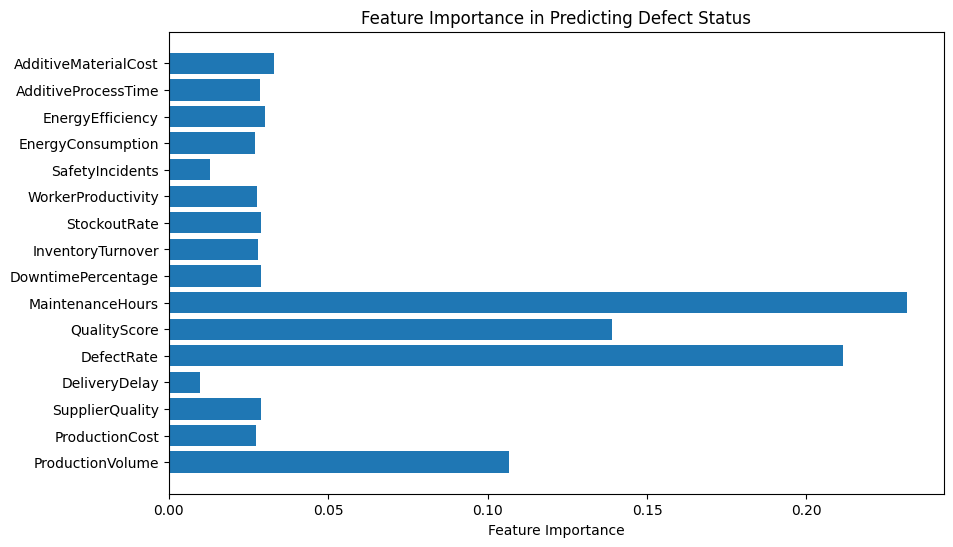

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import os

# defect_analysis 폴더 경로 설정 (올바른 경로로 수정)
save_dir = "/Users/brian/Desktop/defect_analysis"
if not os.path.exists(save_dir):  # 폴더가 존재하지 않으면 생성
    os.makedirs(save_dir)

# 데이터셋 로드 (올바른 경로로 수정)
file_path = '/content/manufacturing_defect_dataset.csv'
df = pd.read_csv(file_path)

# 데이터 첫 몇 줄 확인
print(df.head())

# 데이터셋의 기본 정보 확인
print(df.info())

# 결측치 확인
print(df.isnull().sum())

# 데이터 통계 정보 확인 (기초 통계량)
print(df.describe())

# 결함 상태 분포 시각화
sns.countplot(x='DefectStatus', data=df)
plt.title('Defect Status Distribution')
plt.savefig(os.path.join(save_dir, 'DefectStatus.png'))  # 그래프 저장
plt.show()

# 주요 변수 간 상관관계 히트맵
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig(os.path.join(save_dir, 'Correlation.png'))  # 그래프 저장
plt.show()

# 특징과 타겟 변수 분리
X = df.drop('DefectStatus', axis=1)  # 모든 변수를 특징으로 사용
y = df['DefectStatus']  # 타겟 변수

# 학습용과 테스트용 데이터 분리 (70% 학습, 30% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 모델 생성
rf_model = RandomForestClassifier(random_state=42)
print("랜덤 포레스트 모델 학습을 시작합니다...")  # 학습 시작 메시지
rf_model.fit(X_train, y_train)
print("랜덤 포레스트 모델 학습이 완료되었습니다.")  # 학습 완료 메시지

# 특징 중요도 추출
importances = rf_model.feature_importances_
features = X.columns

# 특징 중요도 시각화
plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Predicting Defect Status')
plt.savefig(os.path.join(save_dir, 'feature_importance.png'))  # 그래프 저장
# 그래프 시각화 후 버퍼 비우기
plt.show()
plt.close()


In [2]:
# prompt: Evaluate the randomforest model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 테스트 데이터로 예측 수행
y_pred = rf_model.predict(X_test)

# 모델 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# 혼동 행렬 출력
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 분류 보고서 출력
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 모델 평가 지표 출력
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
 [[116  32]
 [  8 816]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.78      0.85       148
           1       0.96      0.99      0.98       824

    accuracy                           0.96       972
   macro avg       0.95      0.89      0.91       972
weighted avg       0.96      0.96      0.96       972

Accuracy: 0.9588477366255144
Precision: 0.9581864951446339
Recall: 0.9588477366255144
F1 Score: 0.9573275467668313


In [3]:
# prompt: do the next step

# 하이퍼파라미터 튜닝을 위한 라이브러리 임포트
from sklearn.model_selection import GridSearchCV

# 튜닝할 하이퍼파라미터 설정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Grid Search를 사용하여 최적의 하이퍼파라미터 찾기
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

# 최적의 하이퍼파라미터로 모델 학습
best_rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf_model.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred_best = best_rf_model.predict(X_test)

# 모델 평가 지표 계산
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, average='weighted')
recall_best = recall_score(y_test, y_pred_best, average='weighted')
f1_best = f1_score(y_test, y_pred_best, average='weighted')

# 혼동 행렬 출력
cm_best = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix (Tuned):\n", cm_best)

# 분류 보고서 출력
print("\nClassification Report (Tuned):\n", classification_report(y_test, y_pred_best))

# 모델 평가 지표 출력
print("Accuracy (Tuned):", accuracy_best)
print("Precision (Tuned):", precision_best)
print("Recall (Tuned):", recall_best)
print("F1 Score (Tuned):", f1_best)


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Confusion Matrix (Tuned):
 [[116  32]
 [  8 816]]

Classification Report (Tuned):
               precision    recall  f1-score   support

           0       0.94      0.78      0.85       148
           1       0.96      0.99      0.98       824

    accuracy                           0.96       972
   macro avg       0.95      0.89      0.91       972
weighted avg       0.96      0.96      0.96       972

Accuracy (Tuned): 0.9588477366255144
Precision (Tuned): 0.9581864951446339
Recall (Tuned): 0.9588477366255144
F1 Score (Tuned): 0.9573275467668313


In [4]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

# XGBoost 모델 생성 및 학습
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Gradient Boosting 모델 생성 및 학습
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# XGBoost 모델 평가
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

# Gradient Boosting 모델 평가
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", accuracy_gb)

# XGBoost와 Gradient Boosting 모델의 성능 비교
print("XGBoost vs Gradient Boosting Accuracy Comparison:")
print("XGBoost:", accuracy_xgb)
print("Gradient Boosting:", accuracy_gb)


XGBoost Accuracy: 0.9557613168724279
Gradient Boosting Accuracy: 0.9557613168724279
XGBoost vs Gradient Boosting Accuracy Comparison:
XGBoost: 0.9557613168724279
Gradient Boosting: 0.9557613168724279


                     Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest (Default)  0.958848   0.958186  0.958848  0.957328
1    Random Forest (Tuned)  0.958848   0.958186  0.958848  0.957328
2                  XGBoost  0.955761   0.954790  0.955761  0.954202
3        Gradient Boosting  0.955761   0.954708  0.955761  0.954351


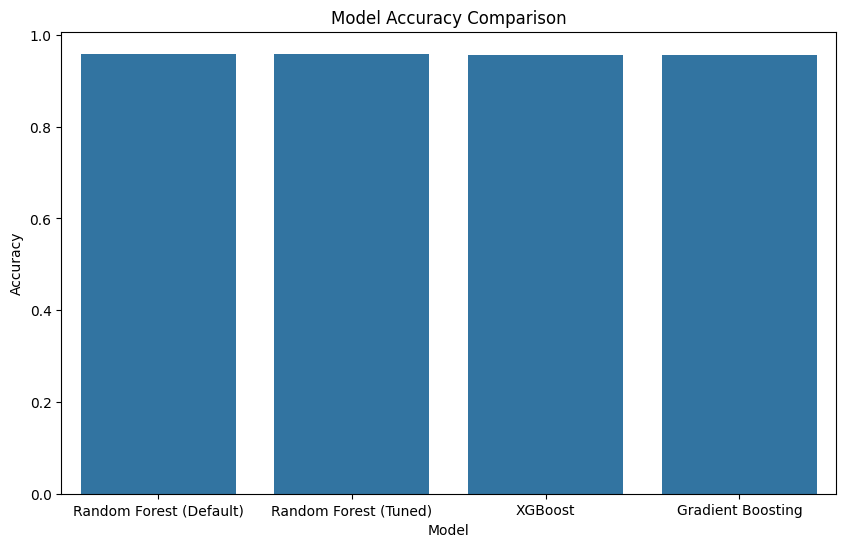

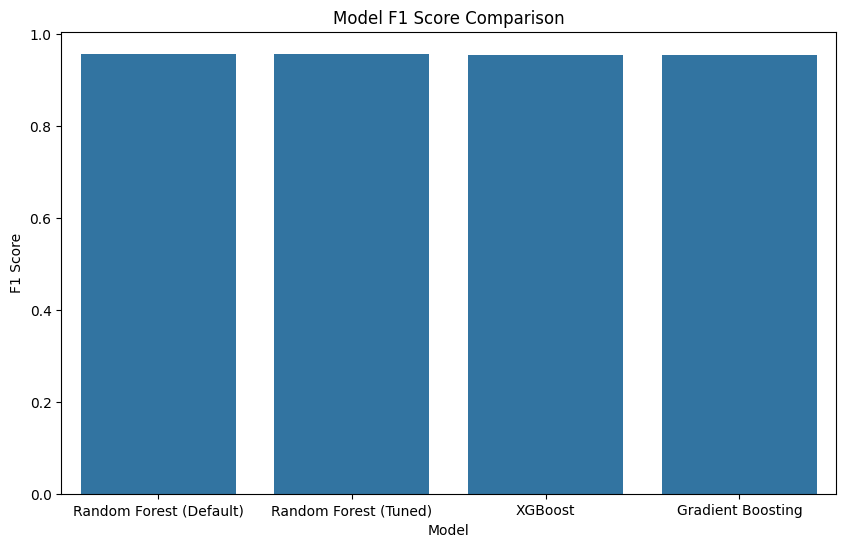

In [5]:
# prompt: compare the capability between the models we made

# 모델 성능 비교를 위한 데이터프레임 생성
model_performance = pd.DataFrame({
    'Model': ['Random Forest (Default)', 'Random Forest (Tuned)', 'XGBoost', 'Gradient Boosting'],
    'Accuracy': [accuracy, accuracy_best, accuracy_xgb, accuracy_gb],
    'Precision': [precision, precision_best, precision_score(y_test, y_pred_xgb, average='weighted'), precision_score(y_test, y_pred_gb, average='weighted')],
    'Recall': [recall, recall_best, recall_score(y_test, y_pred_xgb, average='weighted'), recall_score(y_test, y_pred_gb, average='weighted')],
    'F1 Score': [f1, f1_best, f1_score(y_test, y_pred_xgb, average='weighted'), f1_score(y_test, y_pred_gb, average='weighted')]
})

# 모델 성능 비교 출력
print(model_performance)

# Accuracy 기준으로 모델 성능 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=model_performance)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(save_dir, 'model_comparison_accuracy.png'))
plt.show()

# F1 Score 기준으로 모델 성능 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1 Score', data=model_performance)
plt.title('Model F1 Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.savefig(os.path.join(save_dir, 'model_comparison_f1.png'))
plt.show()


In [6]:
# 모델 성능 비교 데이터프레임에서 Accuracy가 가장 높은 모델 찾기
best_model = model_performance.loc[model_performance['Accuracy'].idxmax()]

# 가장 성능이 좋은 모델 출력
print("Best Model based on Accuracy:")
print(best_model)


Best Model based on Accuracy:
Model        Random Forest (Default)
Accuracy                    0.958848
Precision                   0.958186
Recall                      0.958848
F1 Score                    0.957328
Name: 0, dtype: object


In [8]:
import joblib

# Save the best model to a file
model_filename = 'best_random_forest_model.pkl'
joblib.dump(best_rf_model, model_filename)


['best_random_forest_model.pkl']

In [9]:
# Load the synthetic test dataset
test_data = pd.DataFrame({
    'ProductionVolume': [373, 421, 782, 225, 209, 594, 516, 776, 488, 737],
    'ProductionCost': [7564.13, 12727.93, 16492.71, 6167.42, 16767.49, 8597.41, 10555.01, 5025.11, 18451.07, 16256.10],
    'SupplierQuality': [92.67, 80.19, 96.89, 92.10, 90.40, 93.54, 88.55, 93.74, 87.43, 81.48],
    'DeliveryDelay': [3, 4, 2, 1, 3, 1, 1, 2, 4, 0],
    'DefectRate': [3.29, 4.63, 2.59, 2.89, 4.97, 0.78, 4.29, 3.58, 3.92, 3.13],
    'QualityScore': [69.21, 68.16, 91.25, 88.66, 81.06, 94.90, 79.69, 68.82, 75.18, 67.39],
    'MaintenanceHours': [23, 16, 15, 4, 19, 17, 8, 20, 1, 6],
    'DowntimePercentage': [0.39, 0.16, 3.08, 3.58, 3.73, 2.20, 1.28, 1.34, 4.19, 3.46],
    'InventoryTurnover': [6.43, 8.62, 8.56, 3.76, 3.64, 5.55, 7.44, 4.43, 8.04, 6.08],
    'StockoutRate': [4.25, 0.30, 4.76, 4.26, 1.11, 5.39, 4.19, 4.94, 2.98, 9.21],
    'WorkerProductivity': [89.56, 93.00, 84.84, 89.94, 92.88, 99.60, 87.03, 81.92, 89.58, 89.05],
    'SafetyIncidents': [2, 8, 1, 4, 0, 2, 2, 5, 9, 4],
    'EnergyConsumption': [3185.12, 4181.27, 3489.83, 3743.07, 3406.36, 1368.83, 4471.60, 4530.33, 1137.05, 4425.88],
    'EnergyEfficiency': [0.28, 0.36, 0.44, 0.16, 0.25, 0.33, 0.39, 0.36, 0.46, 0.29],
    'AdditiveProcessTime': [5.02, 5.94, 5.68, 2.12, 3.70, 7.45, 9.69, 6.74, 1.68, 5.62],
    'AdditiveMaterialCost': [332.31, 217.78, 113.52, 253.79, 343.28, 177.48, 415.36, 101.20, 137.81, 195.00]
})

# Load the trained Random Forest model (replace 'best_random_forest_model.pkl' with your actual model file)
model_filename = 'best_random_forest_model.pkl'
best_model = joblib.load(model_filename)

# Use the model to predict on the synthetic test data
predictions = best_model.predict(test_data)

# Display the predictions
print("Predictions for test data:", predictions)


Predictions for test data: [1 1 1 0 1 1 1 1 1 1]
